In [38]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GroupShuffleSplit, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv('../../data/answerList_data.csv')
df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | ((df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


In [40]:
def calculate_ttr(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens) if tokens else 0
    return ttr

df['TTR'] = df['Answer.explanation'].astype(str).apply(calculate_ttr)
df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1,0.937500
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1,0.923077
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1,0.827586
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1,1.000000
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1,0.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,3,Graduate_Student,2.0,28,Male,University,USA,C#,1,0.766667
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000


In [41]:
df['Answer.option.int'] = df['Answer.option'].map({'NO': 0, 'IDK': 0.5, 'YES': 1})
df['Worker.gender.int'] = df['Worker.gender'].map({'Male': -1, 'Other': 0, 'Female': 1})


In [42]:
df_holdout = df[df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]
df_train = df[~df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]

df_train

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int
320,621,HIT03_6,16,225.484,4,2,0,0,1,0,...,20.0,35,Male,High School;University,US,c++,1,0.875000,0.0,-1
321,622,HIT03_6,16,75.758,5,2,0,0,1,0,...,5.0,26,Male,High School;University,USA,Java,1,0.708333,0.0,-1
322,623,HIT03_6,16,396.716,5,2,0,0,0,0,...,10.0,33,Male,University,United States,Java,0,0.576923,1.0,-1
323,624,HIT03_6,16,899.377,4,3,0,0,1,0,...,5.0,33,Male,University;Web,USA,matlab; js,1,1.000000,0.0,-1
324,625,HIT03_6,16,253.272,0,5,0,0,0,0,...,3.0,49,Female,University,US,php,0,1.000000,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,2.0,28,Male,University,USA,C#,1,0.766667,0.0,-1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571,1.0,-1
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,10.0,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000,0.0,-1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000,0.0,-1


## First Tree: Decision Tree Classifier

In [43]:
input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X = df_train[input_cols]
y = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.82945736 0.81524927 0.64130435 0.81395349 0.70408163 0.70833333]
Mean Precision: 0.7520632388979717
Recall for each fold: [0.72297297 0.79202279 0.62765957 0.7977208  0.6969697  0.68686869]
Mean Recall: 0.7207024201705053
Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.75531915 0.7591623  0.80530973 0.64130435 0.65217391 0.70408163]
Mean Precision: 0.7195585134394987
Recall for each fold: [0.7434555  0.7591623  0.81981982 0.62765957 0.63829787 0.6969697 ]
Mean Recall: 0.7142274607741914
Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.82111437 0.80263158 0.80803571 0.80088496 0.80803571 0.63829787]
Mean Precision: 0.7798333675188168
Recall for each fold: [0.7977208  0.82432432 0.81531532 0.81531532 0.81531532 0.63829787]
Mean Recall: 0.7843814900552489
Mean Precision train: 1.0
Mean Recall train: 1.0
Precision for each fold: [0.65957447 0.81305638 0.8080

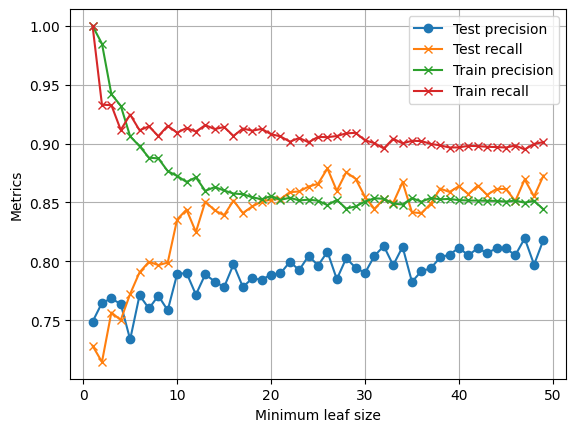

In [44]:
def get_decision_tree_classifier(min_samples_leaf, return_model=True):
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)

    cv_results = cross_validate(
        clf, X, y, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )

    print("Mean Precision train:", np.mean(cv_results['train_precision']))
    print("Mean Recall train:", np.mean(cv_results['train_recall']))

    print("Precision for each fold:", cv_results['test_precision'])
    print("Mean Precision:", np.mean(cv_results['test_precision']))

    print("Recall for each fold:", cv_results['test_recall'])
    print("Mean Recall:", np.mean(cv_results['test_recall']))

    best_model_idx = np.argmax(cv_results['test_precision'])
    best_model = cv_results['estimator'][best_model_idx]

    if not return_model:
         return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall'])

    return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall']), best_model



max_val = 50
def avg_decision_tree_classifier(x, runs=10):
    results = [get_decision_tree_classifier(x, return_model=False) for _ in range(runs)]
    avg_result = tuple(sum(values) / runs for values in zip(*results))
    return avg_result

vals = [avg_decision_tree_classifier(x) for x in range(1, max_val)]

y1_vals, y2_vals, y3_vals, y4_vals = zip(*vals)

# Plot both elements of the tuple
plt.plot(range(1, max_val), y1_vals, label='Test precision', marker='o')
plt.plot(range(1, max_val), y2_vals, label='Test recall', marker='x')
plt.plot(range(1, max_val), y3_vals, label='Train precision', marker='x')
plt.plot(range(1, max_val), y4_vals, label='Train recall', marker='x')
plt.xlabel('Minimum leaf size')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
best_model_decision_tree_classifier = get_decision_tree_classifier(20)[4]

plt.figure(figsize=(200, 100))
plot_tree(best_model_decision_tree_classifier, filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str), rounded=True, fontsize=9)
plt.title("Decision Tree of Best Model Based on Precision")
plt.show()

Mean Precision train: 0.8560985813597822
Mean Recall train: 0.9109762988876265
Precision for each fold: [0.89380531 0.7027027  0.79901961 0.79901961 0.65217391 0.82845188]
Mean Precision: 0.7791955040020263
Recall for each fold: [0.90990991 0.78787879 0.85340314 0.85340314 0.79787234 0.89189189]
Mean Recall: 0.8490598688047725


## Second Tree: Gradient Boosted Decision Tree

Increase precision from average 0.775 to 0,82

In [46]:
from sklearn.ensemble import GradientBoostingClassifier


input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X_gb = df_train[input_cols]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = GradientBoostingClassifier(min_samples_leaf=20)


precision_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='precision')
recall_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='recall')

print("Precision for each group split:", precision_scores)
print("Mean Precision:", np.mean(precision_scores))

print("Recall for each group split:", recall_scores)
print("Mean Recall:", np.mean(recall_scores))

Precision for each group split: [0.8313253  0.82142857 0.90723982 0.82142857 0.8313253  0.68421053]
Mean Precision: 0.8161596817645158
Recall for each group split: [0.69148936 0.90315315 0.84293194 0.84293194 0.93243243 0.77777778]
Mean Recall: 0.8317860999018402


## Third Tree: Minimal number of input columns
Very high recall but low precision --> many positives (false and true)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier


input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols_minimal = ['Answer.confidence', 'Answer.difficulty', 'Worker.score', 'Worker.yearsOfExperience']
output_col = 'correctness'

X_gb = df_train[input_cols_minimal]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = GradientBoostingClassifier(random_state=42)


precision_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='precision')
recall_scores = cross_val_score(clf, X_gb, y_gb, cv=gss, groups=groups, scoring='recall')

print("Precision for each group split:", precision_scores)
print("Mean Precision:", np.mean(precision_scores))

print("Recall for each group split:", recall_scores)
print("Mean Recall:", np.mean(recall_scores))


Precision for each group split: [0.73508772 0.73       0.67647059 0.67647059 0.58333333 0.76888889]
Mean Precision: 0.6950418529985094
Recall for each group split: [0.94369369 0.96335079 0.98648649 0.96335079 0.94369369 0.98648649]
Mean Recall: 0.9645103218401648


In [48]:
df_train

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int
320,621,HIT03_6,16,225.484,4,2,0,0,1,0,...,20.0,35,Male,High School;University,US,c++,1,0.875000,0.0,-1
321,622,HIT03_6,16,75.758,5,2,0,0,1,0,...,5.0,26,Male,High School;University,USA,Java,1,0.708333,0.0,-1
322,623,HIT03_6,16,396.716,5,2,0,0,0,0,...,10.0,33,Male,University,United States,Java,0,0.576923,1.0,-1
323,624,HIT03_6,16,899.377,4,3,0,0,1,0,...,5.0,33,Male,University;Web,USA,matlab; js,1,1.000000,0.0,-1
324,625,HIT03_6,16,253.272,0,5,0,0,0,0,...,3.0,49,Female,University,US,php,0,1.000000,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,2.0,28,Male,University,USA,C#,1,0.766667,0.0,-1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571,1.0,-1
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,10.0,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000,0.0,-1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000,0.0,-1


Adding the workers' professions somehow makes it worse. Maybe I did something wrong here.

In [49]:
df_train['Worker.profession.int'] = df_train['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})
df_train

/var/folders/f7/k6ksdyss1rdd4kq9f0lc_kl00000gn/T/ipykernel_58821/3285624595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Worker.profession.int'] = df_train['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int,Worker.profession.int
320,621,HIT03_6,16,225.484,4,2,0,0,1,0,...,35,Male,High School;University,US,c++,1,0.875000,0.0,-1,0
321,622,HIT03_6,16,75.758,5,2,0,0,1,0,...,26,Male,High School;University,USA,Java,1,0.708333,0.0,-1,3
322,623,HIT03_6,16,396.716,5,2,0,0,0,0,...,33,Male,University,United States,Java,0,0.576923,1.0,-1,4
323,624,HIT03_6,16,899.377,4,3,0,0,1,0,...,33,Male,University;Web,USA,matlab; js,1,1.000000,0.0,-1,1
324,625,HIT03_6,16,253.272,0,5,0,0,0,0,...,49,Female,University,US,php,0,1.000000,0.5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,28,Male,University,USA,C#,1,0.766667,0.0,-1,3
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,39,Male,University;Web,USA,C#; VB.NET; Java,0,0.928571,1.0,-1,4
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,31,Male,High School;University;Web;Other work,usa,C++,1,1.000000,0.0,-1,4
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,1.000000,0.0,-1,2


## Holdout set predicition

In [50]:
groups = df_holdout.groupby('FailingMethod')

precision_per_group = {}
recall_per_group = {}

for method, group in groups:
    X_group = group[input_cols]
    y_group = group[output_col]

    y_pred = best_model_decision_tree_classifier.predict(X_group)

    precision = precision_score(y_group, y_pred)
    recall = recall_score(y_group, y_pred)

    precision_per_group[method] = precision
    recall_per_group[method] = recall

for method in precision_per_group:
    print(f"FailingMethod: {method}")
    print(f"Precision: {precision_per_group[method]}")
    print(f"Recall: {recall_per_group[method]}")
    print("-" * 30)


FailingMethod: HIT01_8
Precision: 0.9178082191780822
Recall: 0.8481012658227848
------------------------------
FailingMethod: HIT02_24
Precision: 0.704225352112676
Recall: 0.7575757575757576
------------------------------


/var/folders/f7/k6ksdyss1rdd4kq9f0lc_kl00000gn/T/ipykernel_58821/1012204187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)


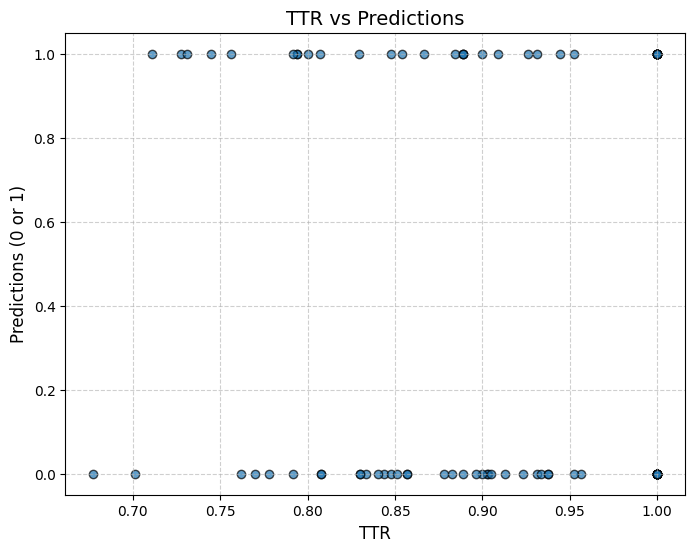

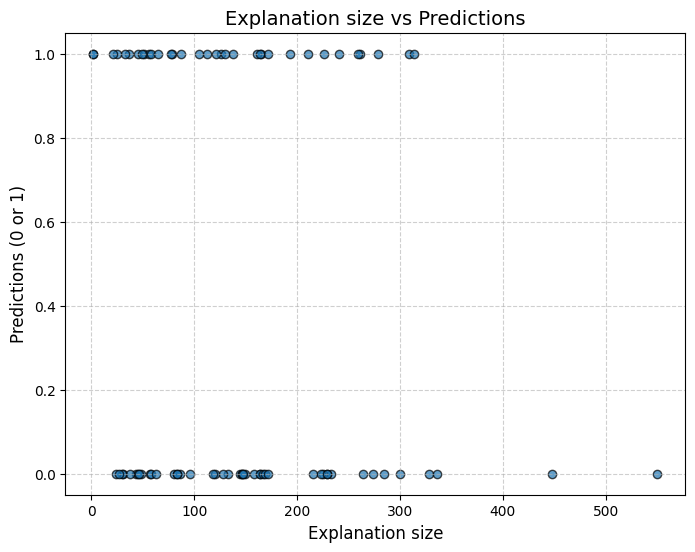

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bug_rows = df_holdout[df_holdout['GroundTruth'] == 1]

bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)

y_pred = best_model_decision_tree_classifier.predict(bug_rows[input_cols])


plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['TTR'], y_pred, alpha=0.7, edgecolor='k')
plt.title('TTR vs Predictions', fontsize=14)
plt.xlabel('TTR', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['Explanation_Size'], y_pred, alpha=0.7, edgecolor='k')
plt.title('Explanation size vs Predictions', fontsize=14)
plt.xlabel('Explanation size', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [52]:
df_holdout[df_holdout['TP'] == 1 ]


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int
20,441,HIT01_8,1,140.407,4,3,1,1,0,0,...,3.0,49,Female,University,US,php,1,1.000000,1.0,1
22,443,HIT01_8,1,112.409,5,2,1,1,0,0,...,5.0,20,Male,University;Web,USA,c#,1,0.931034,1.0,-1
23,444,HIT01_8,1,76.418,5,1,1,1,0,0,...,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1,0.903226,1.0,-1
24,445,HIT01_8,1,261.928,5,2,1,1,0,0,...,1.0,25,Female,University,USA,java,1,0.770000,1.0,1
25,446,HIT01_8,1,236.045,5,1,1,1,0,0,...,5.0,29,Male,University;Other On the job,USA,Python; SQL; Java,1,0.882353,1.0,-1
27,448,HIT01_8,1,259.790,3,3,1,1,0,0,...,1.0,30,Female,University,united states,none,1,0.902439,1.0,1
28,449,HIT01_8,1,230.142,4,3,1,1,0,0,...,4.0,35,Male,High School,USA,php and C++,1,0.830189,1.0,-1
29,450,HIT01_8,1,253.302,4,2,1,1,0,0,...,4.0,35,Male,University;Web;Other MOOC,USA,Java Python,1,0.761905,1.0,-1
30,451,HIT01_8,1,89.521,4,3,1,1,0,0,...,14.0,34,Male,High School;University;Web;Other books,Russia,C++;Object Pascal,1,0.937500,1.0,-1
34,455,HIT01_8,1,161.419,4,4,1,1,0,0,...,2.0,24,Male,University,India,c; c++,1,0.807692,1.0,-1


In [58]:
from openai import OpenAI

question_groups = df_holdout[df_holdout['TP'] == 1 ].groupby(['FailingMethod', 'Question.ID'])
client = OpenAI(
    api_key=""
)

explanations_list = []

for m, group in question_groups:
    explanations = group['Answer.explanation'].to_list()
    explanations_list.append(explanations)
    print('Number of explanations', len(group['Answer.explanation']))


print('Number of groups', len(question_groups))


Number of explanations 12
Number of explanations 15
Number of explanations 4
Number of explanations 9
Number of explanations 9
Number of groups 5


In [59]:
def get_prompt_1(explanations):
        return f"""
I give you the following task, after that the relevant data. You have to solve the task with the data (filtered explanations) I give you, each separate explanation is separated by a newline character

for the correct answers to the inspection tasks hosting the bug, prompt the LLM
to generate a single explanation by merging the participants’ explanations in a way that minimizes
redundant information, while keeping the information that would be necessary for someone else to fix the
bug.
• Types of information that, if present in the explanation, should be preserved - how the program works,
how the failure is happening, what is problem in the code, etc.

{explanations}

"""

def get_prompt_2(explanations):
        return f"""
Please summarize these reports of the same bug. Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. Summarize the report of the bug concisely. Keep the summary as short as possible.

These the reports:

{explanations}

"""

In [55]:
for explanations in explanations_list:
    print(get_prompt_2(str(explanations)))


Please summarize these reports of the same bug. Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. Summarize the report of the bug concisely. Keep the summary as short as possible.

These the reports:

['Minutes are set to -15; which is less then 0 and it throws illegal arg exception', 'In the code there is a check that 0 <= minutes < 60 and the minutesOffset is -15 which does not fall into these prarmeters thus throwing an Exception', 'There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)', 'YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 279 should read "if (

In [60]:
from tqdm import tqdm


def get_results(get_prompt_function):

    results = []

    for explanations in tqdm(explanations_list):

        chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": get_prompt_function(str(explanations)),
            }
        ],
        model="gpt-4o-mini",
    )

        results.append(chat_completion.choices[0].message.content)

    results_df = pd.DataFrame(results, columns=['text']).reset_index()

    results_df['complexity'] = results_df['text'].astype(str).apply(calculate_ttr)
    results_df['length'] = results_df['text'].astype(str).apply(len)

    return results_df

In [61]:
from IPython.core.display import Markdown

prompt_1_results = get_results(get_prompt_1)
prompt_2_results = get_results(get_prompt_2)

display(prompt_1_results)
display(prompt_2_results)


100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


,index,text,complexity,length
0,0,The issue revolves around the variable `minute...,0.628571,1328
1,1,The issue arises when the program attempts to ...,0.641304,1213
2,2,The program experiences an issue related to th...,0.657895,697
3,3,The issue arises from the handling of color va...,0.583756,1189
4,4,The bug causing an exception in the Color clas...,0.615385,1040


,index,text,complexity,length
0,0,The bug is caused by the check on line 279 of ...,0.741071,725
1,1,**Bug Summary:**\n\nThe method throws an `Ille...,0.772727,612
2,2,The reports indicate a bug related to time off...,0.739130,392
3,3,"Summary of the Bug Report:\n\nThe variable ""g""...",0.735294,603
4,4,The bug report indicates that an exception is ...,0.628319,632


In [62]:
for index, result in enumerate(prompt_2_results['text']):
    display(Markdown(f'## Result for Text {index + 1}'))
    display(Markdown(result))

## Result for Text 1

The bug is caused by the check on line 279 of the code, which evaluates the `minutesOffset` variable. This variable can be set to negative values, such as -15 (e.g., from `DateTimeZone.forOffsetHoursMinutes(-2, -15)`), but the current condition incorrectly restricts it to the range of 0 to 59. The line should be modified to `if (minutesOffset < -59 || minutesOffset > 59)` to accommodate valid negative values. The current validation throws an `IllegalArgumentException` for any negative input, which does not align with the documentation stating that `minutesOffset` can be negative. This issue prevents the method from proceeding correctly and needs to be fixed to avoid the error "Minutes out of range: + minutesOffset."

## Result for Text 2

**Bug Summary:**

The method throws an `IllegalArgumentException` when the `minutes` parameter is less than 0. Specifically, when calling `DateTimeZone.forOffsetHoursMinutes(-2, -15)`, the conditional on line 279 (`minutesOffset < 0`) rejects the valid case of negative minutes when hours are also negative. The comment block states that `minutesOffset` should be between -59 and +59, but the current implementation only checks for values less than 0. The code should be updated to allow negative minutes when the hour value is also negative, ensuring that the range check correctly accommodates both parameters.

## Result for Text 3

The reports indicate a bug related to time offset handling in the code. The main issue is at line 279, where the variable "minutesOffSet" incorrectly throws an exception if it is less than 0; it should instead check if it is less than -59. Additionally, the offset variable at line 284 is zero, which can lead to "millis out of range" errors. Fixing these conditions should resolve the issue.

## Result for Text 4

Summary of the Bug Report:

The variable "g" must be within the range of 0-255, but it's being assigned a value of -0.5, causing it to exceed the valid range for a Color object. The code does not sanitize the input to ensure it is positive, and the variable "value" is incorrectly used instead of "v" on line 117, leading to a potential negative value. Additionally, the Color constructor requires three float parameters between 0.0 and 1.0, and the argument being passed does not conform to this requirement. Ensure that all parameter checks align with the expected bounds to prevent illegal arguments.

## Result for Text 5

The bug report indicates that an exception is thrown from the Color class due to an improper value for the variable g. It appears that g is calculated from a potentially negative parameter, which could lead to g being a negative integer. This negative value is not acceptable for the Color constructor, which expects g to be within a specific range. There is a suggestion to check the definitions of lowerBound and upperBound for further clarity, as well as an assertion that g should be computed using v instead of value. It is noted that using (int) to define g might also cause a parameter error, and g should ideally be a float.

In [63]:
import nltk
from rouge import Rouge

def calculate_bleu(hyp, ref):
    hypothesis = hyp.split()
    reference = ref.split()
    return nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)

rouge = Rouge()
def calculate_rouge(hyp, ref):
    scores = rouge.get_scores(hyp, ref)
    return scores[0]['rouge-1']['f']

In [64]:
explanation_indices = []
hyp_texts = []
ref_texts = []
bleu_vals = []
rouge_vals = []

for index, explanations in enumerate(explanations_list):
    hyp = prompt_2_results.iloc[index]['text']


    for ref in explanations:
        if len(ref.split(' ')) < 5:
            continue
        explanation_indices.append(index)
        hyp_texts.append(hyp)
        ref_texts.append(ref)
        bleu_vals.append(calculate_bleu(hyp, ref))
        rouge_vals.append(calculate_rouge(hyp, ref))

data = {
    'Explanation index': explanation_indices,
    'Hyp text': hyp_texts,
    'Ref text': ref_texts,
    'bleu': bleu_vals,
    'rouge': rouge_vals,
}


similarity_metrics = pd.DataFrame(data)

similarity_metrics


/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

,Explanation index,Hyp text,Ref text,bleu,rouge
0,0,The bug is caused by the check on line 279 of ...,Minutes are set to -15; which is less then 0 a...,2.375798e-155,0.160000
1,0,The bug is caused by the check on line 279 of ...,In the code there is a check that 0 <= minutes...,8.215655e-79,0.234234
2,0,The bug is caused by the check on line 279 of ...,There is a logical check for if minuteOffset i...,2.987407e-155,0.196429
3,0,The bug is caused by the check on line 279 of ...,YES. The issue is on line 279 (as I explained ...,7.709204e-02,0.372671
4,0,The bug is caused by the check on line 279 of ...,"The variable ""minutesOffset"" is checked incorr...",3.995600e-155,0.263158
5,0,The bug is caused by the check on line 279 of ...,This variable contains a value of -15 as set b...,2.949344e-155,0.311475
6,0,The bug is caused by the check on line 279 of ...,Yes; the variable gets set to -15 through the ...,1.589184e-78,0.346457
7,0,The bug is caused by the check on line 279 of ...,As noted in the comments; valid input for minu...,8.315759e-02,0.348485
8,0,The bug is caused by the check on line 279 of ...,"the variable should be defined as ""unsigned in...",3.126726e-155,0.141414
9,0,The bug is caused by the check on line 279 of ...,The value of minutes offset does not have vali...,2.512100e-155,0.171429
